In [1]:
DATA_PATH = r'/home/luis-felipe/Uncertainty_Estimation/data'
#CORRUPTED_DATA_PATH = os.path.join(DATA_PATH,'corrupted')

PATH_MODELS = r'/home/luis-felipe/Uncertainty_Estimation/torch_models'
PATH_trainer = r'/home/luis-felipe/Uncertainty_Estimation/torch_models/trainer'

In [12]:
import os
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from collections import defaultdict
import copy

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

True


In [4]:
import NN_models as models
import NN_utils as utils
import NN_utils.train_and_eval as TE
import cifar_data

In [5]:
from uncertainty.MonteCarlo_Dropout import MonteCarloDropout
from uncertainty.ensemble import Ensemble
import uncertainty.metrics as metrics
from uncertainty import TestAugmentation as _TTA
from uncertainty.MCBN import MonteCarloBatchNormalization as MCBN

## um

In [6]:
MODEL_ARC = 'VGG_16'
DATA = 'Cifar100'
NAME = MODEL_ARC +'_' + DATA 

data = cifar_data.__dict__[DATA](data_dir = DATA_PATH)
model_class = models.__dict__[MODEL_ARC]

model_path = os.path.join(PATH_MODELS,MODEL_ARC)
weights_path = os.path.join(model_path,DATA)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
files = [f for f in os.listdir(weights_path) if os.path.isfile(os.path.join(weights_path, f)) and f.endswith(".pt")]
files = sorted(files)

In [8]:
model = model_class(num_classes = data.n_classes)
model.eval()
model.softmax = True
state_dict = torch.load(os.path.join(weights_path,files[0]))
model.load_state_dict(state_dict)
TE.model_acc(model,data.test_dataloader)

/home/luis-felipe/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


71.51

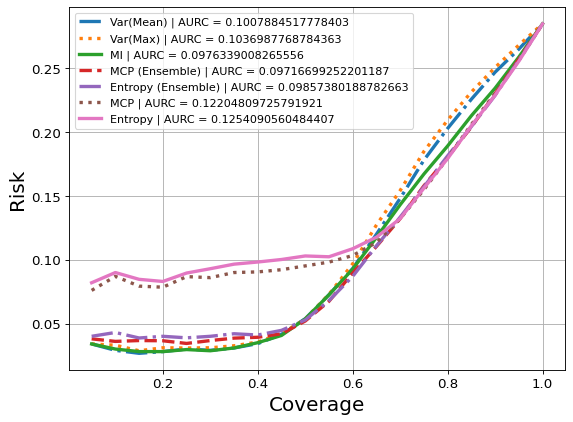

In [27]:
model_mcd = MonteCarloDropout(model,5,as_ensemble=False).to(dev)
RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.plot_RC(aurc = True)

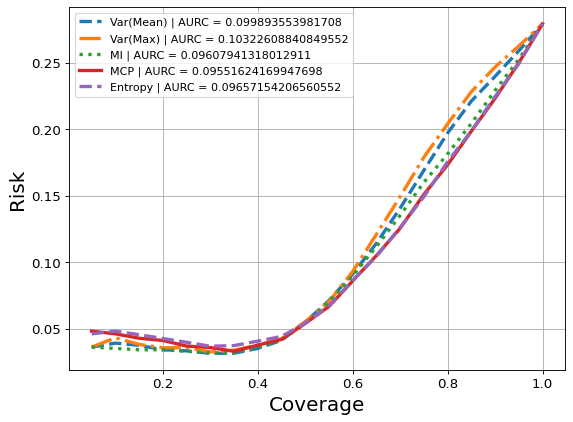

In [24]:
model_mcd = MonteCarloDropout(model,5).to(dev)
RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
RC.plot_RC(aurc = True)

In [25]:
RC.correlation()

,Var(Mean),Var(Max),MI,MCP,Entropy
Var(Mean),1.0,0.991208,0.984701,0.954556,0.936431
Var(Max),0.991208,1.0,0.973217,0.938223,0.926101
MI,0.984701,0.973217,1.0,0.968779,0.963058
MCP,0.954556,0.938223,0.968779,1.0,0.991711
Entropy,0.936431,0.926101,0.963058,0.991711,1.0


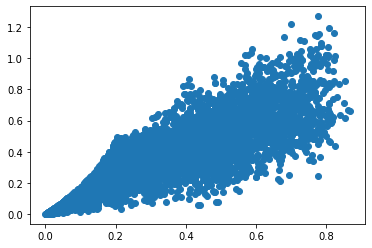

In [26]:
plt.plot(RC.d_uncs['MCP'].cpu().numpy(),RC.d_uncs['MI'].cpu().numpy(),'o')

## todos

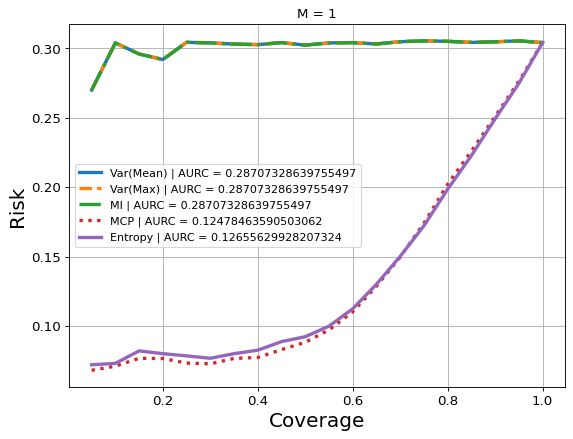

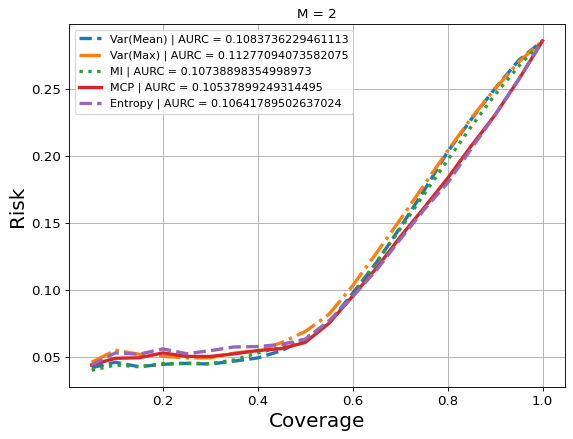

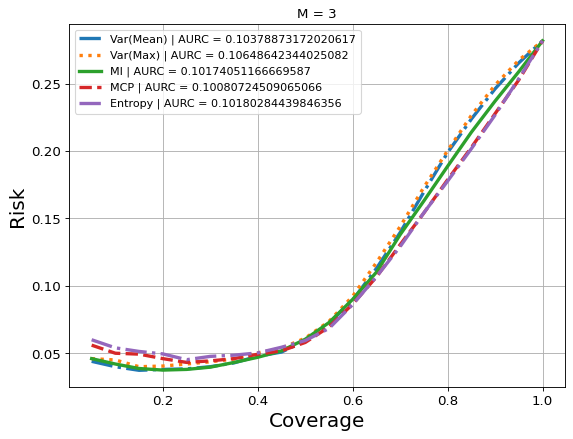

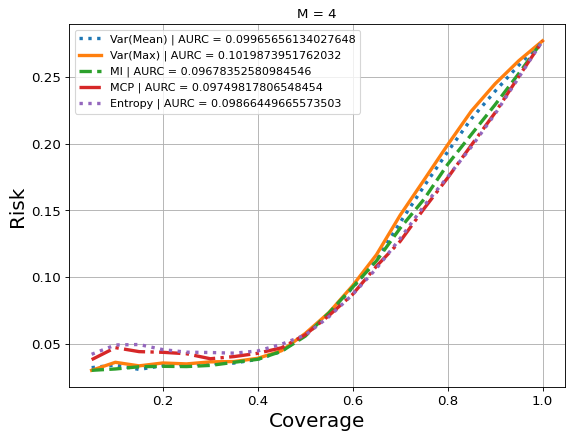

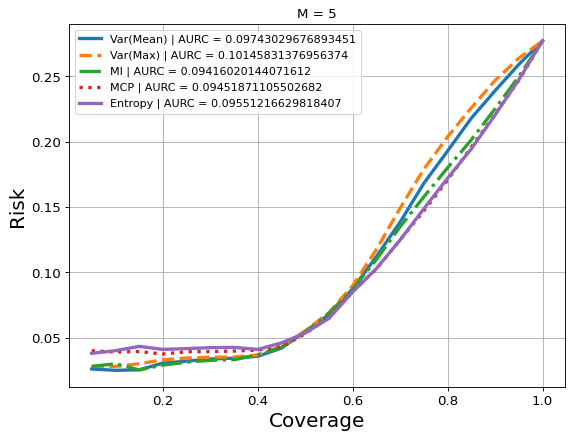

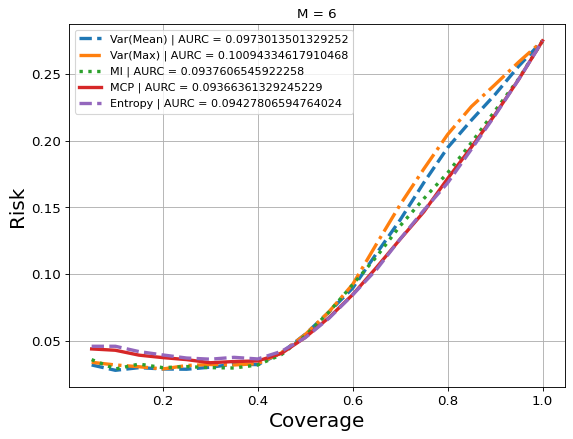

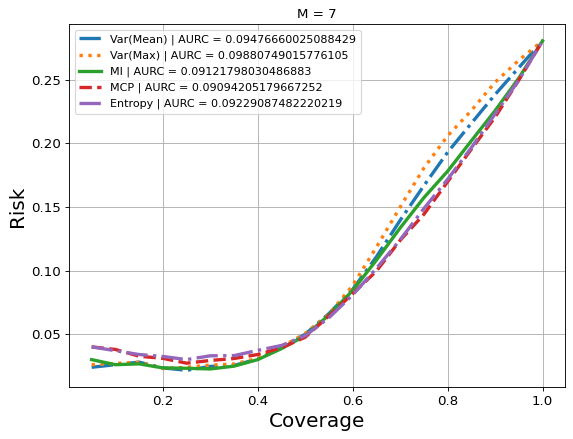

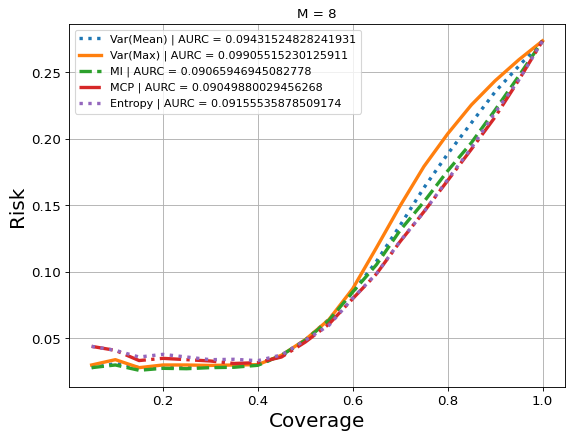

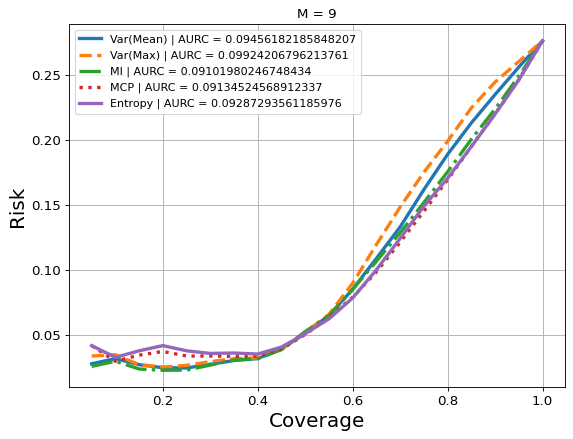

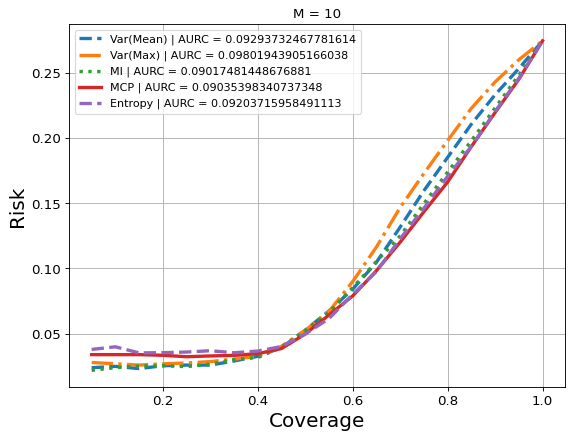

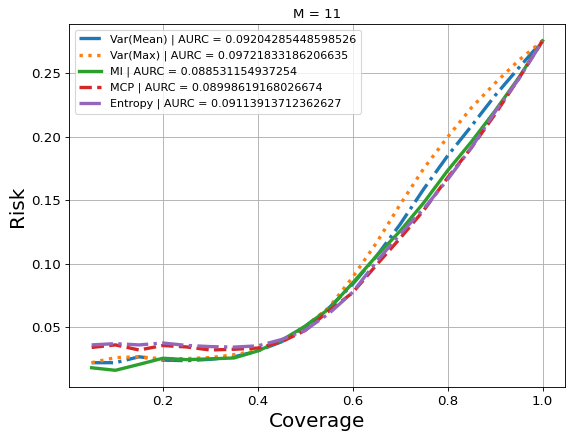

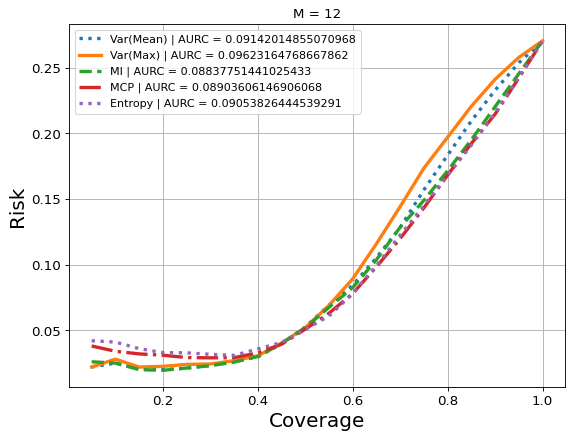

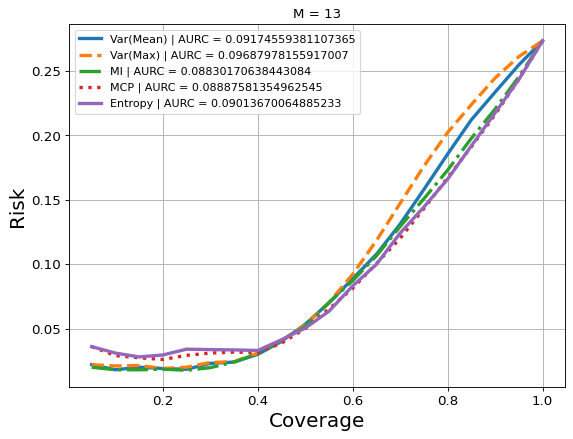

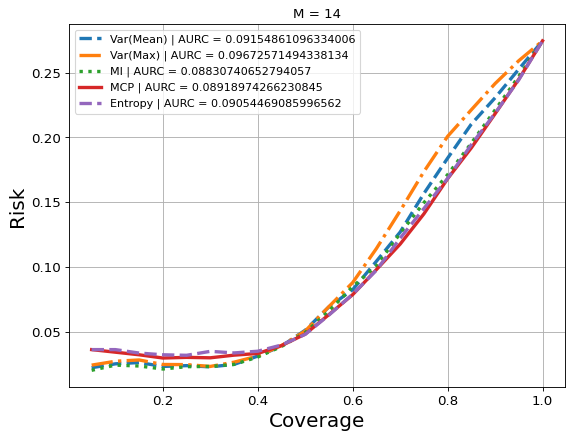

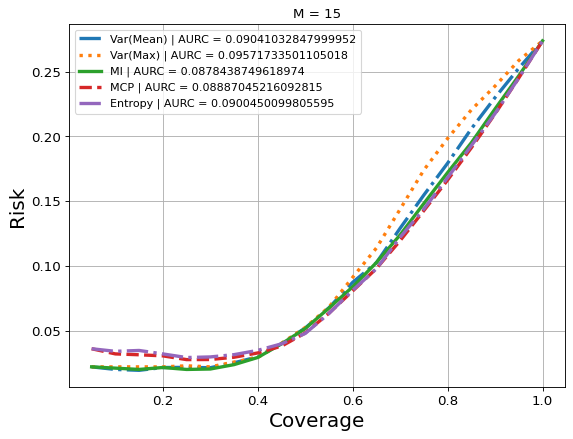

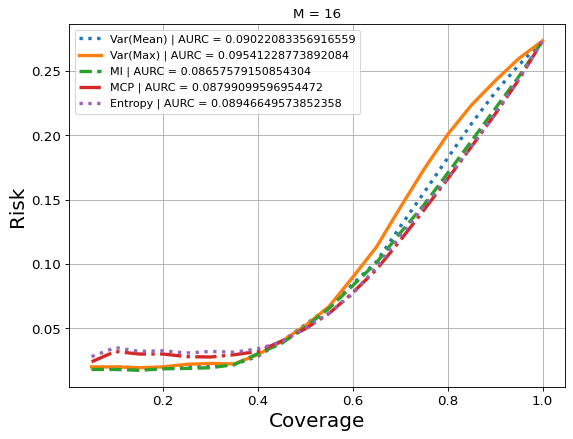

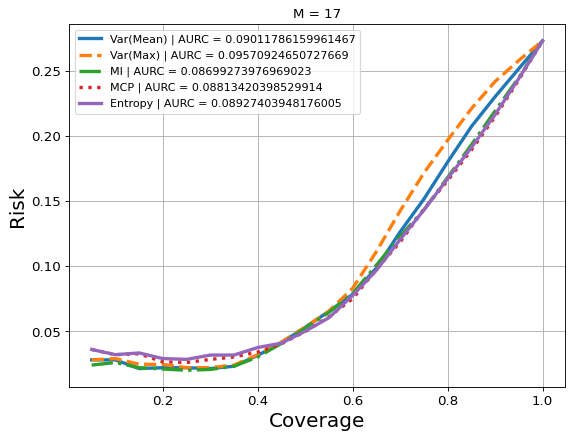

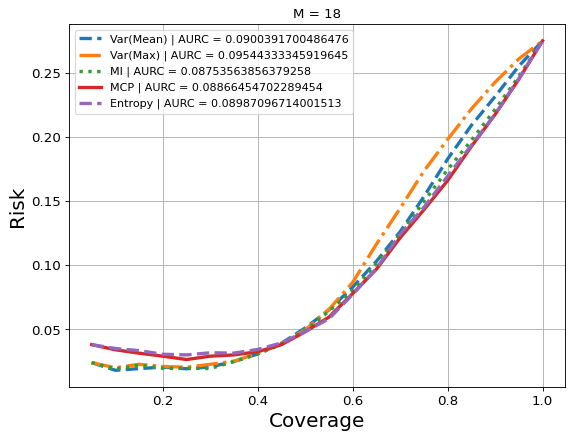

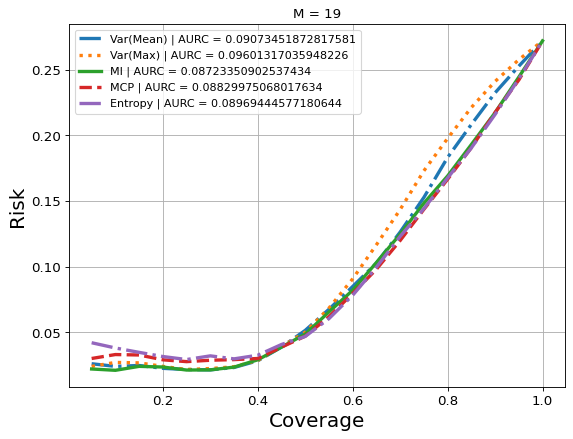

In [9]:
for N_ENS in range(1,20):
    model_mcd = MonteCarloDropout(model,N_ENS).to(dev)
    TE.model_acc(model_mcd,data.test_dataloader, set_eval = False)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    RC.plot_RC(aurc = True)
    plt.title(f'M = {N_ENS}')
    plt.show()


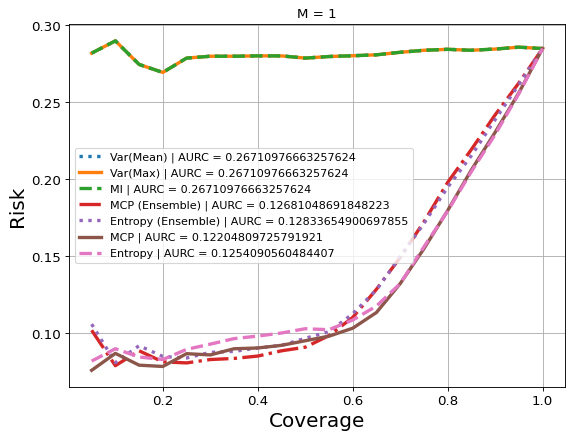

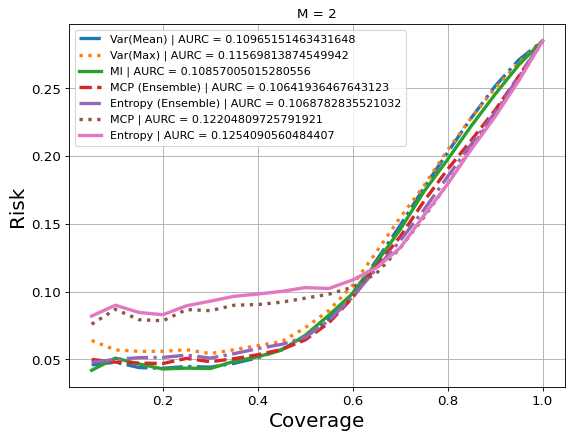

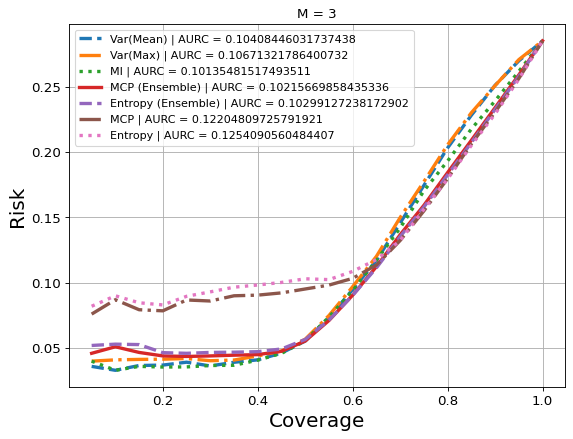

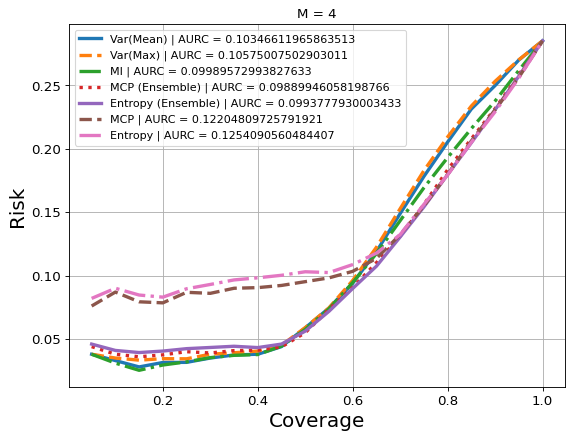

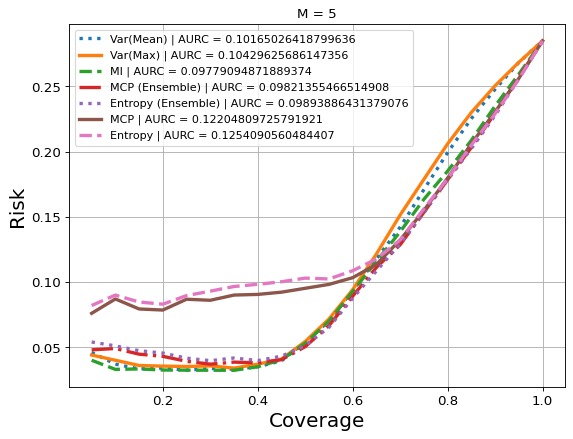

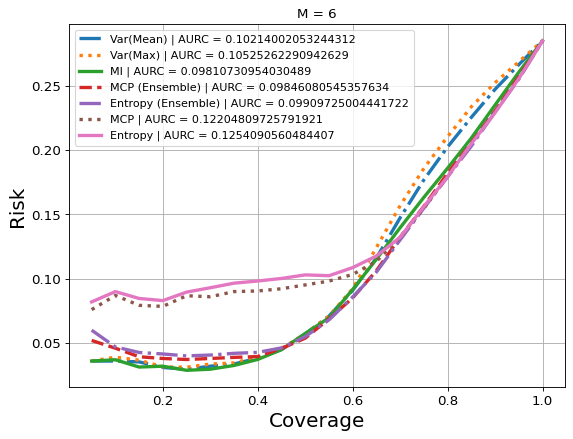

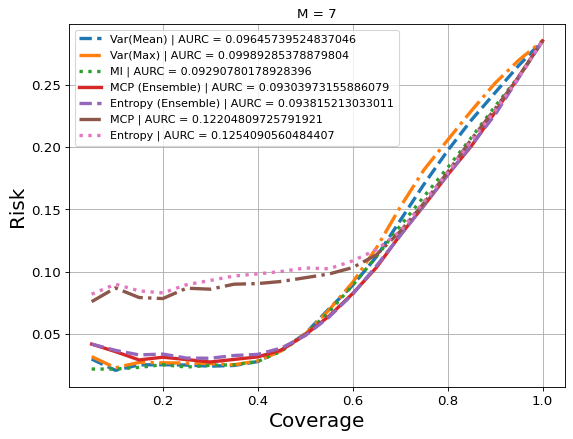

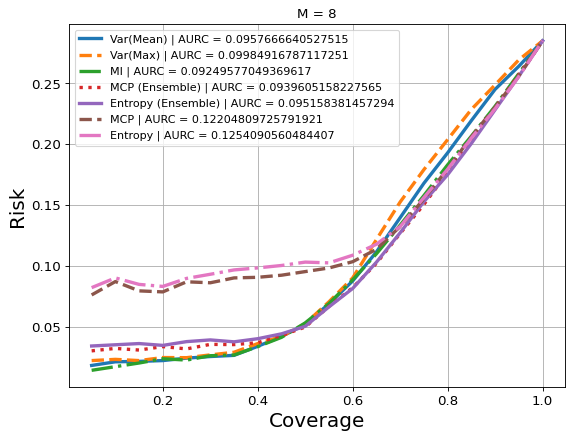

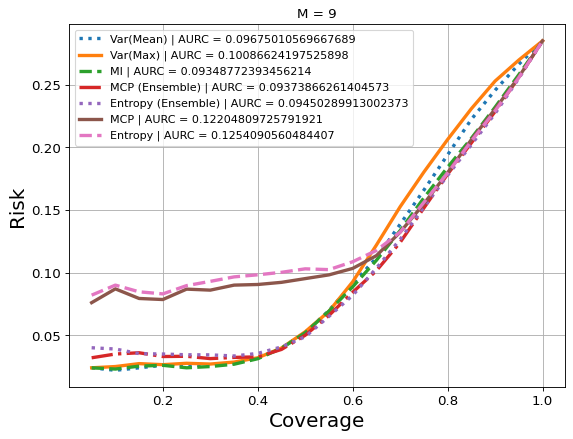

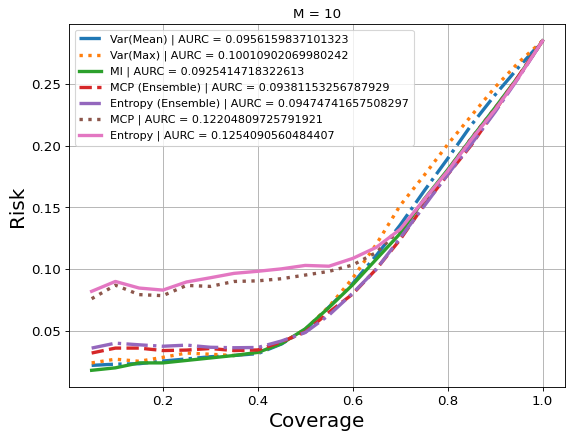

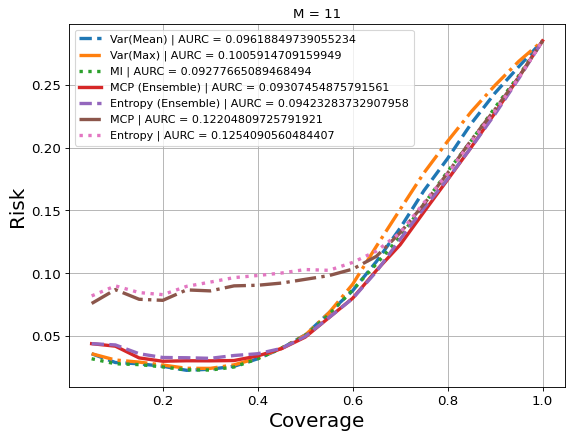

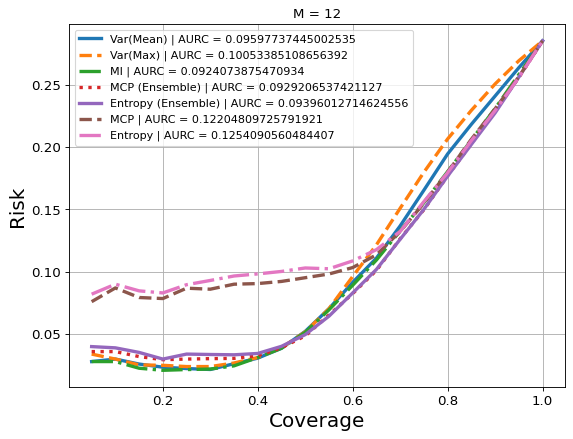

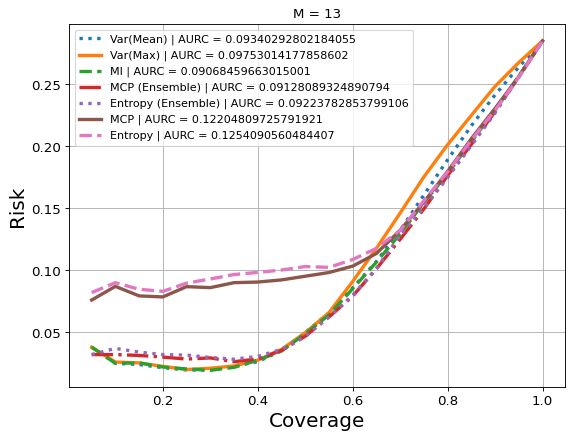

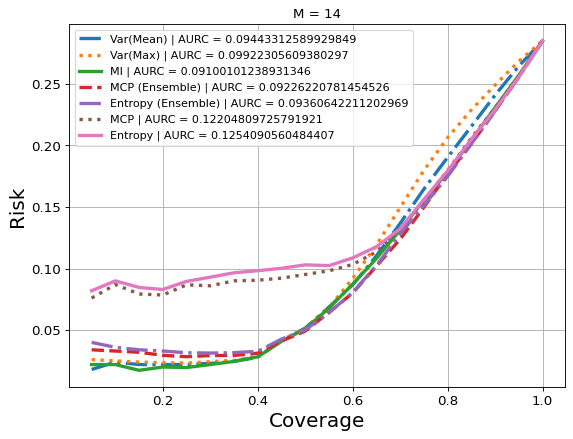

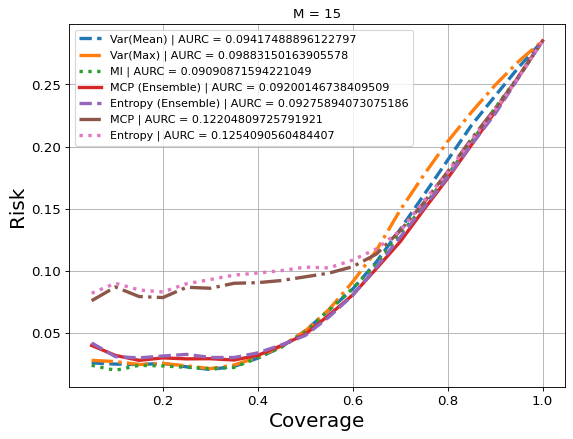

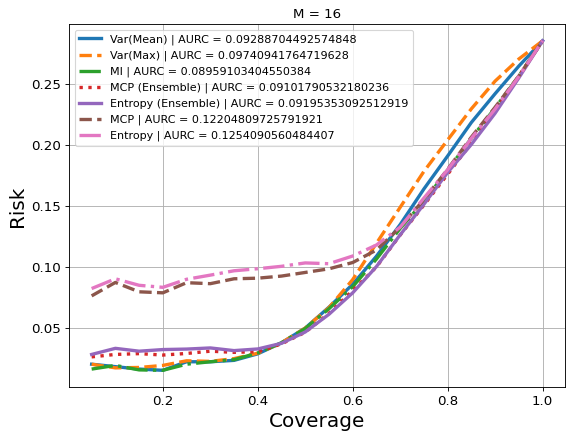

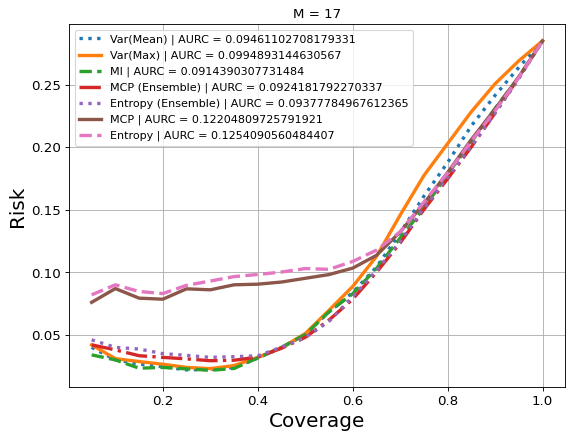

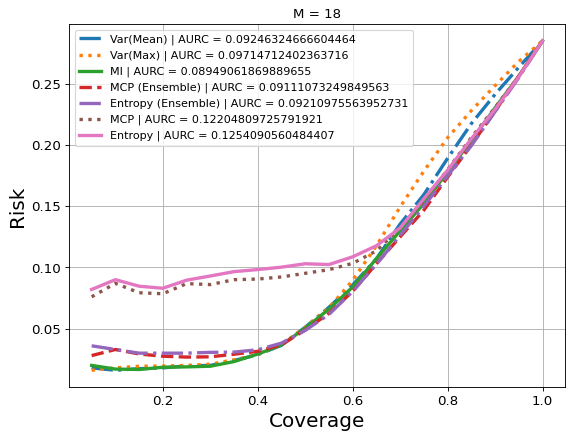

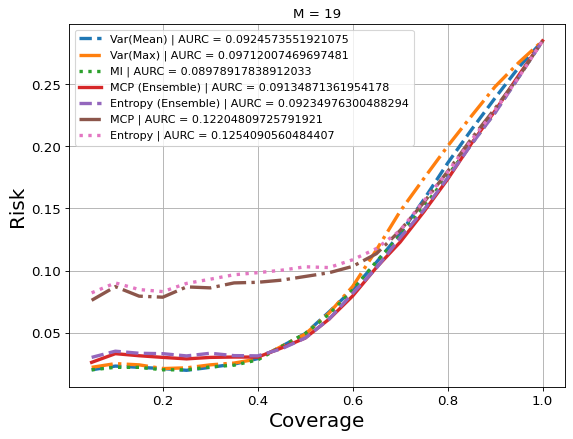

In [10]:
for N_ENS in range(1,20):
    model_mcd = MonteCarloDropout(model,N_ENS,as_ensemble = False).to(dev)
    TE.model_acc(model_mcd,data.test_dataloader, set_eval = False)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    RC.plot_RC(aurc = True)
    plt.title(f'M = {N_ENS}')
    plt.show()

## todos2

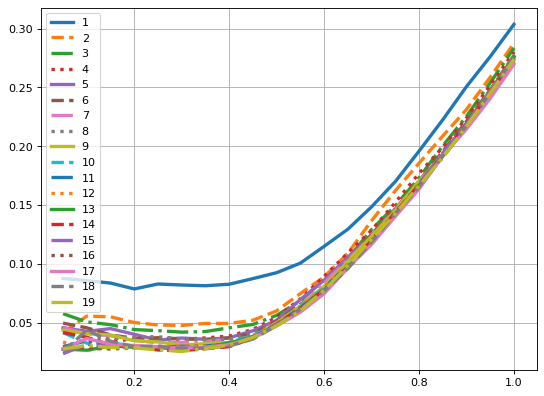

In [13]:
uncs = ['MCP']#, 'MI']
plt.figure(figsize=RC.FIGSIZE, dpi=80)
for N_ENS in range(1,20):
    model_mcd = MonteCarloDropout(model,N_ENS).to(dev)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    d_uncs_ = copy.copy(RC.d_uncs)
    RC.d_uncs = utils.slice_dict(d_uncs_,uncs)
    risks = RC.RC_curves()
    for name,risk in risks.items():
        label = N_ENS
        plt.plot(RC.c_list,risk, label = label, linewidth = RC.LINEWIDTH,linestyle = next(RC.linecycler))
    
#plt.title(f'M = {N_ENS}')
plt.grid()
plt.legend()
plt.show()

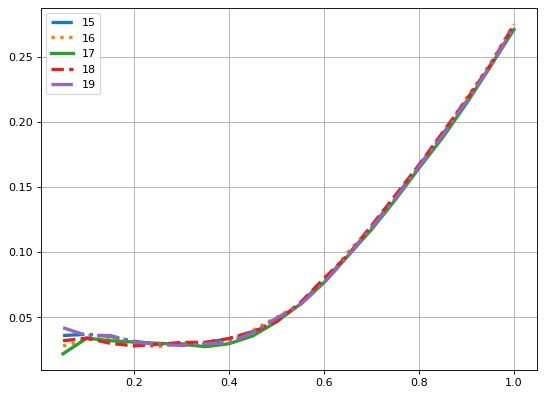

In [15]:
uncs = ['MCP']#, 'MI']
plt.figure(figsize=RC.FIGSIZE, dpi=80)
for N_ENS in range(15,20):
    model_mcd = MonteCarloDropout(model,N_ENS).to(dev)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    d_uncs_ = copy.copy(RC.d_uncs)
    RC.d_uncs = utils.slice_dict(d_uncs_,uncs)
    risks = RC.RC_curves()
    for name,risk in risks.items():
        label = N_ENS
        plt.plot(RC.c_list,risk, label = label, linewidth = RC.LINEWIDTH,linestyle = next(RC.linecycler))
    
#plt.title(f'M = {N_ENS}')
plt.grid()
plt.legend()
plt.show()

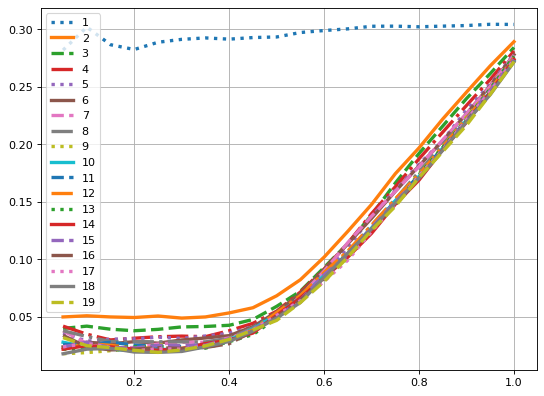

In [16]:
uncs = ['MI']#, 'MI']
plt.figure(figsize=RC.FIGSIZE, dpi=80)
for N_ENS in range(1,20):
    model_mcd = MonteCarloDropout(model,N_ENS).to(dev)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    d_uncs_ = copy.copy(RC.d_uncs)
    RC.d_uncs = utils.slice_dict(d_uncs_,uncs)
    risks = RC.RC_curves()
    for name,risk in risks.items():
        label = N_ENS
        plt.plot(RC.c_list,risk, label = label, linewidth = RC.LINEWIDTH,linestyle = next(RC.linecycler))
    
#plt.title(f'M = {N_ENS}')
plt.grid()
plt.legend()
plt.show()

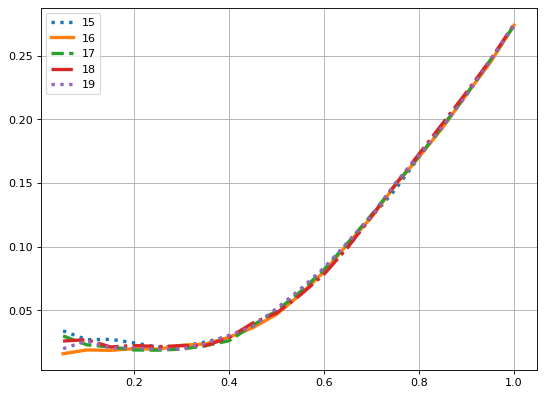

In [20]:
uncs = ['MI']#, 'MI']
plt.figure(figsize=RC.FIGSIZE, dpi=80)
for N_ENS in range(15,20):
    model_mcd = MonteCarloDropout(model,N_ENS).to(dev)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    d_uncs_ = copy.copy(RC.d_uncs)
    RC.d_uncs = utils.slice_dict(d_uncs_,uncs)
    risks = RC.RC_curves()
    for name,risk in risks.items():
        label = N_ENS
        plt.plot(RC.c_list,risk, label = label, linewidth = RC.LINEWIDTH,linestyle = next(RC.linecycler))
    
#plt.title(f'M = {N_ENS}')
plt.grid()
plt.legend()
plt.show()

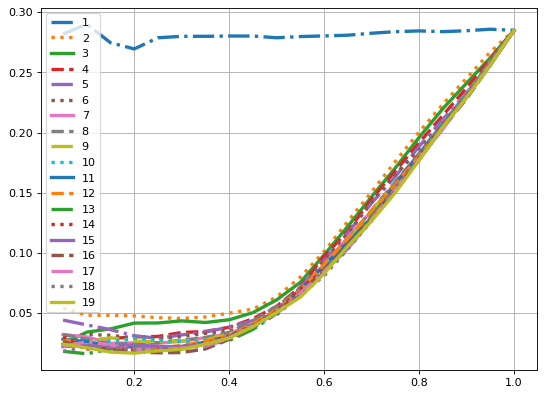

In [17]:
uncs = ['MI']#, 'MI']
plt.figure(figsize=RC.FIGSIZE, dpi=80)
for N_ENS in range(1,20):
    model_mcd = MonteCarloDropout(model,N_ENS,as_ensemble = False).to(dev)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    d_uncs_ = copy.copy(RC.d_uncs)
    RC.d_uncs = utils.slice_dict(d_uncs_,uncs)
    risks = RC.RC_curves()
    for name,risk in risks.items():
        label = N_ENS
        plt.plot(RC.c_list,risk, label = label, linewidth = RC.LINEWIDTH,linestyle = next(RC.linecycler))
    
#plt.title(f'M = {N_ENS}')
plt.grid()
plt.legend()
plt.show()

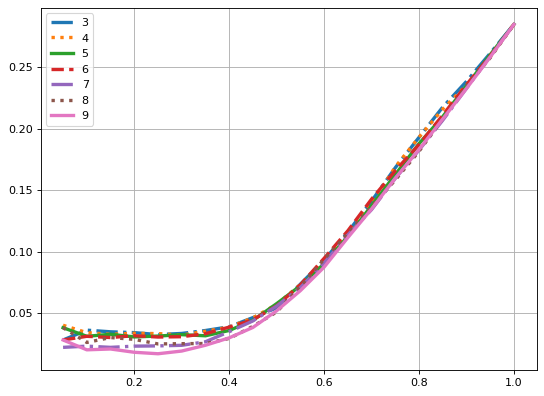

In [23]:
uncs = ['MI']#, 'MI']
plt.figure(figsize=RC.FIGSIZE, dpi=80)
for N_ENS in range(3,12):
    model_mcd = MonteCarloDropout(model,N_ENS,as_ensemble = False).to(dev)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    d_uncs_ = copy.copy(RC.d_uncs)
    RC.d_uncs = utils.slice_dict(d_uncs_,uncs)
    risks = RC.RC_curves()
    for name,risk in risks.items():
        label = N_ENS
        plt.plot(RC.c_list,risk, label = label, linewidth = RC.LINEWIDTH,linestyle = next(RC.linecycler))
    
#plt.title(f'M = {N_ENS}')
plt.grid()
plt.legend()
plt.show()

KeyboardInterrupt: 

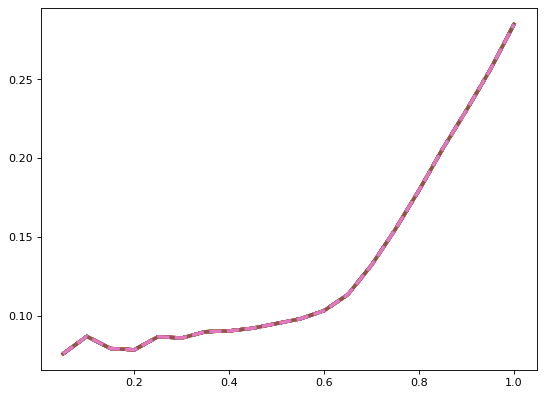

In [28]:
uncs = ['MCP']#, 'MI']
plt.figure(figsize=RC.FIGSIZE, dpi=80)
for N_ENS in range(1,20):
    model_mcd = MonteCarloDropout(model,N_ENS,as_ensemble = False).to(dev)
    RC = metrics.selective_metrics(model_mcd,data.test_dataloader, c_list = np.arange(0.05,1.05,0.05))
    d_uncs_ = copy.copy(RC.d_uncs)
    RC.d_uncs = utils.slice_dict(d_uncs_,uncs)
    risks = RC.RC_curves()
    for name,risk in risks.items():
        label = N_ENS
        plt.plot(RC.c_list,risk, label = label, linewidth = RC.LINEWIDTH,linestyle = next(RC.linecycler))
    
#plt.title(f'M = {N_ENS}')
plt.grid()
plt.legend()
plt.show()